# QQQ / QLD / TQQQ + 年化避險成本壓力測試
比較 1x / 2x / 3x 槓桿 + Put 避險效果
- **QQQ**: 1x (無槓桿)
- **Synthetic QLD**: 2x 槓桿模擬
- **Synthetic TQQQ**: 3x 槓桿模擬

回溯至 1999 年，涵蓋 2000/2008/2020/2022

In [1]:
%matplotlib inline
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
import datetime

plt.style.use('seaborn-v0_8')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def black_scholes_put_price(S, K, T, r, sigma):
    if T <= 0:
        return max(K - S, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def find_strike_for_budget(S, T, r, sigma, budget, target_quantity):
    if target_quantity <= 0 or budget <= 0:
        return 0.0
    target_price = budget / target_quantity
    def objective(K):
        if K <= 0: return -target_price
        return black_scholes_put_price(S, K, T, r, sigma) - target_price
    try:
        return brentq(objective, S * 0.01, S * 2.0)
    except:
        return 0.0

def create_synthetic_leveraged(qqq_prices, leverage, expense_ratio):
    """使用 QQQ 日報酬模擬槓桿 ETF"""
    daily_expense = expense_ratio / 252
    qqq_returns = qqq_prices.pct_change().fillna(0)
    leveraged_returns = leverage * qqq_returns - daily_expense
    return (1 + leveraged_returns).cumprod() * 100

In [3]:
print("下載資料...")
data = yf.download(['QQQ', '^VXN', '^TNX'], start='1999-03-10', progress=True)

df = pd.DataFrame()
if isinstance(data.columns, pd.MultiIndex):
    df['QQQ_Price'] = data['Close']['QQQ']
    df['VXN'] = data['Close']['^VXN']
    df['TNX'] = data['Close']['^TNX']

df = df.dropna()
df['Rate'] = df['TNX'] / 100.0
df['Sigma'] = df['VXN'] / 100.0

# 建立三種槓桿版本
df['QQQ'] = create_synthetic_leveraged(df['QQQ_Price'], 1, 0.002)      # QQQ ~0.2% ER
df['QLD'] = create_synthetic_leveraged(df['QQQ_Price'], 2, 0.0095)    # QLD ~0.95% ER
df['TQQQ'] = create_synthetic_leveraged(df['QQQ_Price'], 3, 0.0095)   # TQQQ ~0.95% ER

print(f"資料範圍: {df.index[0].date()} ~ {df.index[-1].date()}, 共 {len(df)} 筆")

下載資料...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed

資料範圍: 2001-01-23 ~ 2026-01-06, 共 6270 筆


In [4]:
def run_backtest(df, leverage_col, leverage_ratio, hedge_cost_pct, initial_wealth=10000):
    """執行單一策略回測"""
    cash = initial_wealth
    shares = 0
    option_holdings = {'quantity': 0, 'strike': 0, 'expiry_date': None}
    value_history = []
    next_rebalance_year = df.index[0].year
    
    for date, row in df.iterrows():
        price = row[leverage_col]
        qqq_price = row['QQQ_Price']
        r, sigma = row['Rate'], row['Sigma']
        
        option_val = 0.0
        if option_holdings['quantity'] > 0:
            days_to_expiry = (option_holdings['expiry_date'] - date).days
            T_remain = max(days_to_expiry / 365.25, 0.0)
            if T_remain <= 0:
                option_val = max(option_holdings['strike'] - qqq_price, 0.0) * option_holdings['quantity']
            else:
                option_val = black_scholes_put_price(qqq_price, option_holdings['strike'], T_remain, r, sigma) * option_holdings['quantity']
        
        if date.year >= next_rebalance_year:
            total_equity = (shares * price) + option_val + (cash if date == df.index[0] else 0)
            cash = total_equity
            shares = 0
            
            budget = cash * hedge_cost_pct
            shares = (cash - budget) / price
            # 保護曝險 = leverage_ratio * 持有市值
            quantity_needed = (leverage_ratio * shares * price) / qqq_price
            strike = find_strike_for_budget(qqq_price, 1.0, r, sigma, budget, quantity_needed)
            
            option_holdings = {'quantity': quantity_needed, 'strike': strike, 'expiry_date': date + datetime.timedelta(days=365)}
            cash = 0
            next_rebalance_year += 1
            option_val = budget
        
        value_history.append((shares * price) + option_val + cash)
    
    return pd.Series(value_history, index=df.index)

In [5]:
# 執行所有策略組合
hedge_costs = [0.0, 0.02, 0.04, 0.08]
leverages = [
    ('QQQ', 'QQQ', 1),
    ('QLD', 'QLD', 2),
    ('TQQQ', 'TQQQ', 3)
]

results = {}

for name, col, lev in leverages:
    for hc in hedge_costs:
        label = f"{name}" if hc == 0 else f"{name} + {int(hc*100)}% Hedge"
        print(f"回測: {label}")
        results[label] = run_backtest(df, col, lev, hc)

res_df = pd.DataFrame(results)
print("\n回測完成!")

C:\Users\Tim\AppData\Local\Temp\ipykernel_31312\439023898.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


回測: QQQ
回測: QQQ + 2% Hedge
回測: QQQ + 4% Hedge
回測: QQQ + 8% Hedge
回測: QLD
回測: QLD + 2% Hedge
回測: QLD + 4% Hedge
回測: QLD + 8% Hedge
回測: TQQQ
回測: TQQQ + 2% Hedge
回測: TQQQ + 4% Hedge
回測: TQQQ + 8% Hedge

回測完成!


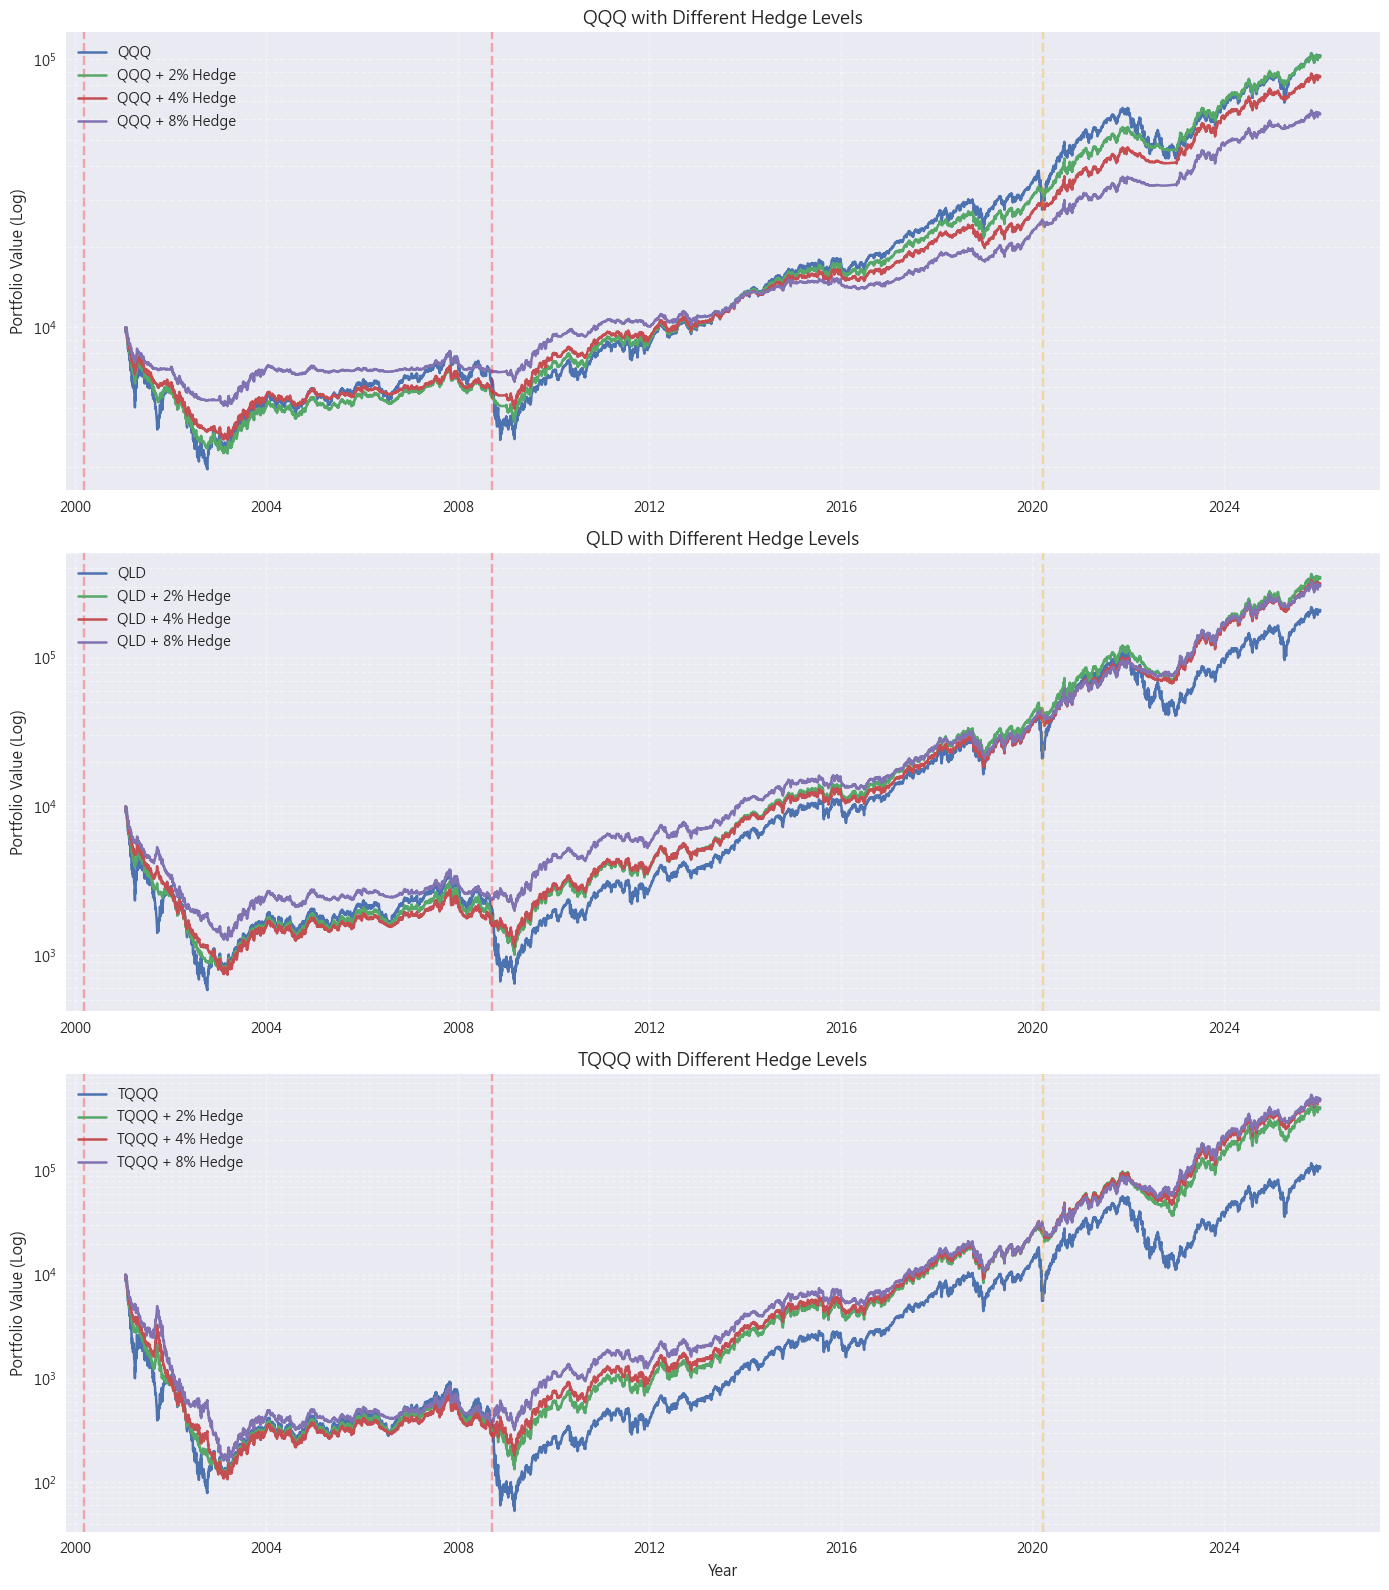

In [6]:
# 繪圖：分開三組槓桿
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

for idx, (name, _, _) in enumerate(leverages):
    ax = axes[idx]
    cols = [c for c in res_df.columns if c.startswith(name)]
    for col in cols:
        ax.plot(res_df.index, res_df[col], label=col, lw=1.8)
    ax.axvline(pd.Timestamp('2000-03-10'), color='red', ls='--', alpha=0.3)
    ax.axvline(pd.Timestamp('2008-09-15'), color='red', ls='--', alpha=0.3)
    ax.axvline(pd.Timestamp('2020-03-23'), color='orange', ls='--', alpha=0.3)
    ax.set_title(f'{name} with Different Hedge Levels', fontsize=13)
    ax.set_yscale('log')
    ax.legend(loc='upper left')
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.set_ylabel('Portfolio Value (Log)')

axes[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()

In [7]:
# 統計表
years = (res_df.index[-1] - res_df.index[0]).days / 365.25
stats = []

for col in res_df.columns:
    final = res_df[col].iloc[-1]
    start = res_df[col].iloc[0]
    cagr = (final / start) ** (1/years) - 1
    max_dd = ((res_df[col] - res_df[col].cummax()) / res_df[col].cummax()).min()
    stats.append({'Strategy': col, 'CAGR': f"{cagr*100:.2f}%", 'Max DD': f"{max_dd*100:.1f}%", 'Final': f"${final:,.0f}"})

stats_df = pd.DataFrame(stats)
display(stats_df)

,Strategy,CAGR,Max DD,Final
0,QQQ,9.82%,-70.5%,"$103,635"
1,QQQ + 2% Hedge,9.80%,-66.2%,"$102,999"
2,QQQ + 4% Hedge,9.03%,-62.0%,"$86,501"
3,QQQ + 8% Hedge,7.64%,-49.3%,"$62,734"
4,QLD,12.95%,-94.2%,"$208,903"
5,QLD + 2% Hedge,15.28%,-92.5%,"$347,140"
6,QLD + 4% Hedge,14.82%,-92.6%,"$314,715"
7,QLD + 8% Hedge,14.68%,-87.4%,"$305,314"
8,TQQQ,10.10%,-99.5%,"$110,450"
9,TQQQ + 2% Hedge,16.04%,-98.9%,"$409,172"


In [8]:
# 分段分析
def period_analysis(name, start_date, end_date):
    print(f"\n{'='*70}\n{name} ({start_date} ~ {end_date})\n{'='*70}")
    for col in res_df.columns:
        try:
            s_idx = res_df.index.get_indexer([pd.Timestamp(start_date)], method='nearest')[0]
            e_idx = res_df.index.get_indexer([pd.Timestamp(end_date)], method='nearest')[0]
            period = res_df[col].iloc[s_idx:e_idx+1]
            ret = (period.iloc[-1] / period.iloc[0] - 1) * 100
            mdd = ((period - period.cummax()) / period.cummax()).min() * 100
            print(f"{col:<25}: Return = {ret:>8.1f}%, Max DD = {mdd:>8.1f}%")
        except:
            pass

period_analysis("2000 泡沫", "2000-03-10", "2002-10-09")
period_analysis("2008 金融海嘯", "2007-10-09", "2009-03-09")
period_analysis("2020 COVID", "2020-02-19", "2020-03-23")
period_analysis("2022 升息", "2022-01-03", "2022-12-28")


2000 泡沫 (2000-03-10 ~ 2002-10-09)
QQQ                      : Return =    -70.5%, Max DD =    -70.5%
QQQ + 2% Hedge           : Return =    -64.7%, Max DD =    -64.7%
QQQ + 4% Hedge           : Return =    -59.2%, Max DD =    -59.2%
QQQ + 8% Hedge           : Return =    -46.7%, Max DD =    -46.7%
QLD                      : Return =    -94.2%, Max DD =    -94.2%
QLD + 2% Hedge           : Return =    -90.9%, Max DD =    -91.0%
QLD + 4% Hedge           : Return =    -88.3%, Max DD =    -88.8%
QLD + 8% Hedge           : Return =    -80.8%, Max DD =    -82.9%
TQQQ                     : Return =    -99.2%, Max DD =    -99.2%
TQQQ + 2% Hedge          : Return =    -97.9%, Max DD =    -98.2%
TQQQ + 4% Hedge          : Return =    -96.9%, Max DD =    -97.6%
TQQQ + 8% Hedge          : Return =    -93.8%, Max DD =    -95.8%

2008 金融海嘯 (2007-10-09 ~ 2009-03-09)
QQQ                      : Return =    -51.7%, Max DD =    -53.5%
QQQ + 2% Hedge           : Return =    -36.1%, Max DD =    -38.0%
QQQ 

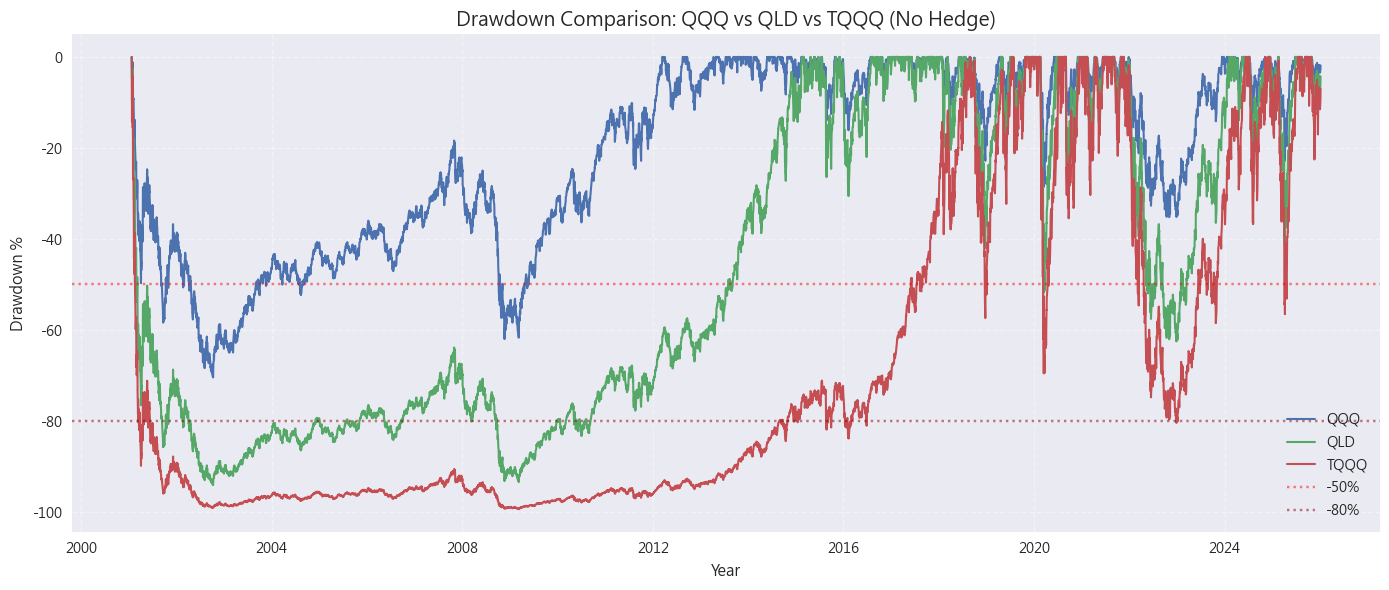

In [9]:
# Drawdown 比較 (只看無避險版本)
fig, ax = plt.subplots(figsize=(14, 6))

for name in ['QQQ', 'QLD', 'TQQQ']:
    dd = (res_df[name] - res_df[name].cummax()) / res_df[name].cummax() * 100
    ax.plot(res_df.index, dd, label=name, lw=1.5)

ax.axhline(-50, color='red', ls=':', alpha=0.5, label='-50%')
ax.axhline(-80, color='darkred', ls=':', alpha=0.5, label='-80%')
ax.set_title('Drawdown Comparison: QQQ vs QLD vs TQQQ (No Hedge)', fontsize=14)
ax.set_ylabel('Drawdown %')
ax.set_xlabel('Year')
ax.legend()
ax.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()